In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, Flatten, MaxPooling2D, Input, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D, Rescaling, Lambda
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
 tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
batch_size = 32
image_size = (48,48)

train_path = 'train'
validation_path = 'val'
test_path = 'test'

def datagen_function(path, aug=False):
    if aug == True:
        generator = ImageDataGenerator(
            rescale = 1 / 128.0,
            rotation_range = 15,
            width_shift_range = 0.15,
            height_shift_range = 0.15,
            shear_range = 0.15,
            zoom_range = 0.15,
            horizontal_flip = True,
            preprocessing_function = preprocess_input
        )
    else:
        generator = ImageDataGenerator(
            rescale = 1 / 128.0,
            preprocessing_function = preprocess_input
        )
    return generator.flow_from_directory(
        path,
        target_size = image_size,
        shuffle = True,
        class_mode = 'categorical',
        batch_size = batch_size
    )
train_gen = datagen_function(train_path, True)
validation_gen = datagen_function(validation_path)
test_gen = datagen_function(test_path)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [5]:
images, labels = next(train_gen)
images[0].shape
images[0]

array([[[ 0.73485154,  0.63453907,  0.580625  ],
        [ 0.73485154,  0.63453907,  0.580625  ],
        [ 0.73485154,  0.63453907,  0.580625  ],
        ...,
        [-0.01357424, -0.11388671, -0.16780078],
        [ 0.6914262 ,  0.59111375,  0.5371997 ],
        [ 0.93661743,  0.83630496,  0.7823909 ]],

       [[ 0.72813445,  0.627822  ,  0.5739079 ],
        [ 0.7291607 ,  0.62884825,  0.5749342 ],
        [ 0.730187  ,  0.6298745 ,  0.57596046],
        ...,
        [ 0.05974072, -0.04057175, -0.09448582],
        [ 0.7724585 ,  0.672146  ,  0.61823195],
        [ 0.9337234 ,  0.8334109 ,  0.77949685]],

       [[ 0.7198121 ,  0.6194996 ,  0.56558555],
        [ 0.72083837,  0.6205259 ,  0.5666118 ],
        [ 0.72186464,  0.62155217,  0.5676381 ],
        ...,
        [ 0.13305563,  0.03274316, -0.02117091],
        [ 0.8534909 ,  0.7531784 ,  0.69926435],
        [ 0.93082947,  0.830517  ,  0.7766029 ]],

       ...,

       [[ 0.70360154,  0.60328907,  0.549375  ],
        [ 0

In [19]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(48, 48, 3))

base_model.trainable = False

model = base_model.layers[-2].output
model = GlobalAveragePooling2D()(model)
model = Dense(7, activation = 'softmax')(model)

model = Model(inputs = base_model.input, outputs = model)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, min_lr = 1e-5, patience = 4, verbose = 0)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience = 5, verbose = 0)
model_checkpoint = ModelCheckpoint('checkpoints/vgg_best.h5', save_best_only=True, monitor='val_acc', mode='max')
csv_logger = CSVLogger('vgg16.log')

model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = 'acc')
history = model.fit(train_gen,validation_data = validation_gen, epochs = 100, callbacks = [early_stopping, reduce_lr, model_checkpoint, csv_logger])

Epoch 1/100
898/898 [==============================] - 49s 52ms/step - loss: 1.3909 - acc: 0.4637 - val_loss: 1.2262 - val_acc: 0.5422 - lr: 1.0000e-04
Epoch 2/100
898/898 [==============================] - 47s 52ms/step - loss: 1.1706 - acc: 0.5560 - val_loss: 1.0877 - val_acc: 0.5879 - lr: 1.0000e-04
Epoch 3/100
898/898 [==============================] - 47s 52ms/step - loss: 1.0878 - acc: 0.5911 - val_loss: 1.0651 - val_acc: 0.5915 - lr: 1.0000e-04
Epoch 4/100
898/898 [==============================] - 47s 52ms/step - loss: 1.0346 - acc: 0.6128 - val_loss: 1.0253 - val_acc: 0.6141 - lr: 1.0000e-04
Epoch 5/100
898/898 [==============================] - 47s 52ms/step - loss: 0.9894 - acc: 0.6316 - val_loss: 0.9985 - val_acc: 0.6272 - lr: 1.0000e-04
Epoch 6/100
898/898 [==============================] - 47s 52ms/step - loss: 0.9533 - acc: 0.6443 - val_loss: 1.0245 - val_acc: 0.6244 - lr: 1.0000e-04
Epoch 7/100
898/898 [==============================] - 47s 52ms/step - loss: 0.9188 - ac

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


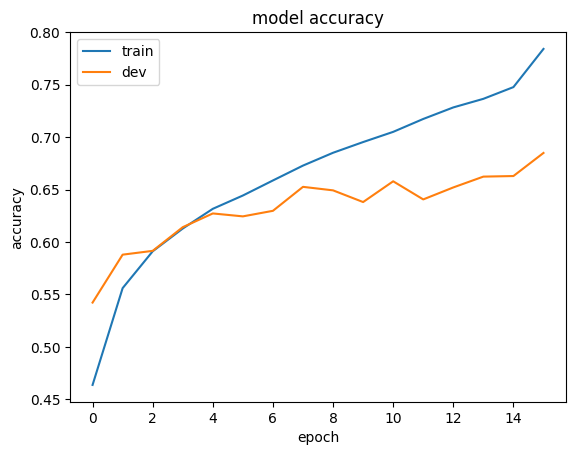

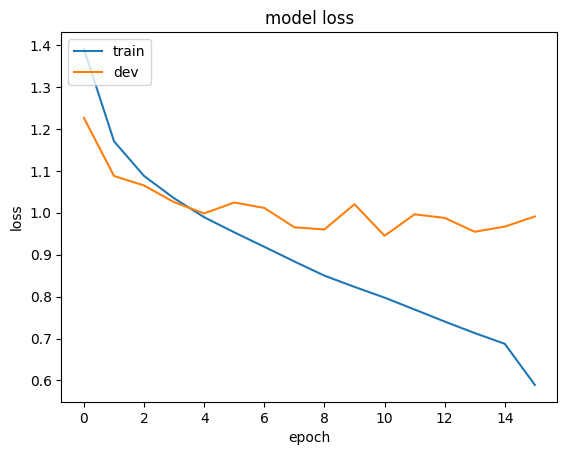

In [12]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [13]:
model.evaluate(test_gen)

113/113 [==============================] - 2s 16ms/step - loss: 0.9528 - acc: 0.6868


[0.9528499841690063, 0.6868208646774292]

In [14]:
history_rev = model.fit(train_gen,validation_data = validation_gen, epochs = 100, callbacks = [reduce_lr, model_checkpoint, csv_logger])

Epoch 1/100
898/898 [==============================] - 47s 52ms/step - loss: 0.5535 - acc: 0.8002 - val_loss: 0.9736 - val_acc: 0.6843 - lr: 5.0000e-05
Epoch 2/100
898/898 [==============================] - 46s 51ms/step - loss: 0.5233 - acc: 0.8108 - val_loss: 1.0297 - val_acc: 0.6812 - lr: 5.0000e-05
Epoch 3/100
898/898 [==============================] - 47s 52ms/step - loss: 0.5030 - acc: 0.8181 - val_loss: 1.0205 - val_acc: 0.6829 - lr: 5.0000e-05
Epoch 4/100
898/898 [==============================] - 46s 52ms/step - loss: 0.4771 - acc: 0.8239 - val_loss: 1.0486 - val_acc: 0.6771 - lr: 5.0000e-05
Epoch 5/100
898/898 [==============================] - 47s 52ms/step - loss: 0.4644 - acc: 0.8325 - val_loss: 1.1071 - val_acc: 0.6726 - lr: 5.0000e-05
Epoch 6/100
898/898 [==============================] - 47s 52ms/step - loss: 0.3922 - acc: 0.8583 - val_loss: 1.0878 - val_acc: 0.6824 - lr: 2.5000e-05
Epoch 7/100
898/898 [==============================] - 47s 52ms/step - loss: 0.3754 - ac

KeyboardInterrupt: 

In [16]:
model_best = load_model("models/VGG16_68V-69T.h5")
model_best.evaluate(test_gen)

113/113 [==============================] - 2s 15ms/step - loss: 0.9528 - acc: 0.6868


[0.9528499245643616, 0.6868208646774292]